### Supervised Machine Learning Models for Cross Species comparison of supporting cells

In [38]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import anndata


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '/home/jovyan/Gonads/Flat_SupportVectorMachine_Fetal/SVM/training/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
backcall            0.2.0
cairo               1.20.0
cffi                1.14.5
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.19.5
packaging           20.9
pandas              1.2.2
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.16
psutil      

'/home/jovyan/my-conda-envs/scanpy_env/bin/python'

**Load our fetal samples**

In [2]:
human = sc.read('/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.h5ad')
human = human[[i in ['female'] for i in human.obs['sex']]]
human.obs['stage'].value_counts()

/home/jovyan/my-conda-envs/scanpy_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


17.0    25715
21.0    21032
10.0    19234
16.0    19233
8.6     14212
13.0    14039
12.0     9631
14.0     9206
8.8      9186
11.0     7913
9.0      7401
7.5      4098
6.0      3773
18.0     3387
8.4      2023
Name: stage, dtype: int64

**Take fine grained annotations on supporting cells**

In [3]:
supporting = pd.read_csv('/nfs/team292/lg18/with_valentina/supporting_nocycling_annotation.csv', index_col = 0)
supporting['annotated_clusters'] = ['preGC_I_OSR1' if i == 'preGC_I_OSR1 ' else i for i in supporting['annotated_clusters']]
print(supporting['annotated_clusters'].value_counts())
supporting = supporting[supporting['annotated_clusters'].isin(['coelEpi', 'sLGR5', 'sPAX8b', 'preGC_III_Notch', 'preGC_II', 
                              'preGC_II_hypoxia', 'preGC_I_OSR1', 'sKITLG',
                                'ovarianSurf'])]

Sertoli             19227
preGC_I_OSR1        11714
Sertoli_low          8763
preGC_II_hypoxia     8180
preGC_III            7871
preGC_II             6669
ovarianSurf          5148
coelEpi              4385
sLGR5                2660
preGC_III_Notch      2409
sPAX8b               1783
sPAX8m               1645
sKITLG               1245
Sertoli_WFDC2        1074
FetalLeydig-like      460
Name: annotated_clusters, dtype: int64


In [4]:
mapping = supporting['annotated_clusters'].to_dict()
human.obs['supporting_clusters'] = human.obs_names.map(mapping)

# Remove doublets as well as NaNs corresponding to cells from enriched samples
human.obs['supporting_clusters'] = human.obs['supporting_clusters'].astype(str)
human = human[[i not in ['nan'] for i in human.obs['supporting_clusters']]]
human.obs['supporting_clusters'].value_counts(dropna = False)

Trying to set attribute `.obs` of view, copying.


preGC_I_OSR1        11712
preGC_II_hypoxia     8178
preGC_II             6645
ovarianSurf          5090
preGC_III_Notch      2409
sLGR5                2380
coelEpi              2223
sPAX8b               1372
sKITLG               1050
Name: supporting_clusters, dtype: int64

In [5]:
### Join sub-states of preGC_II and preGC_III
joined = {'coelEpi' : 'coelEpi', 'sLGR5' : 'sLGR5', 'sPAX8b' : 'sPAX8b', 'preGC_III_Notch' : 'preGC_III', 'preGC_II' : 'preGC_II', 
                              'preGC_II_hypoxia' : 'preGC_II', 'preGC_I_OSR1' : 'preGC_I_OSR1', 'sKITLG' : 'sKITLG',
                                'ovarianSurf' : 'ovarianSurf'}
human.obs['supporting_clusters'] = human.obs['supporting_clusters'].map(joined)
human.obs['supporting_clusters'].value_counts(dropna = False)

Trying to set attribute `.obs` of view, copying.


preGC_II        14823
preGC_I_OSR1    11712
ovarianSurf      5090
preGC_III        2409
sLGR5            2380
coelEpi          2223
sPAX8b           1372
sKITLG           1050
Name: supporting_clusters, dtype: int64

**Intersect genes present in all fetal gonads scRNAseq datasets of human and monkey**

Monkey ovary

In [6]:
monkey = sc.read('/nfs/team292/vl6/Monkey_Zhao/supporting_mesothelial.h5ad')
monkey = anndata.AnnData(X= monkey.raw.X, var=monkey.raw.var, obs=monkey.obs)
monkey

AnnData object with n_obs × n_vars = 2981 × 15078
    obs: 'stage', 'percent_mito', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'doublet_score_0.75', 'leiden', 'cell_type'
    var: 'monkey_ENSEMBL', 'human_ENSEMBL', 'human_gene_ortholog', 'monkey_gene_name', 'n_cells'

Extract the genes from all datasets

In [7]:
human_genes = human.var_names.to_list()
monkey_genes = monkey.var_names.to_list()

In [8]:
from functools import reduce
inters = reduce(np.intersect1d, (human_genes, monkey_genes))
len(inters)

14870

In [9]:
print(inters)

['A1CF' 'A2M' 'A2ML1' ... 'ZYG11B' 'ZYX' 'ZZEF1']


#### Remove cell cycle genes that can bias the classifier

In [10]:
cell_cycle_genes = [x.strip() for x in open(file='/nfs/users/nfs_v/vl6/regev_lab_cell_cycle_genes.txt')]
cell_cycle_genes = [x for x in cell_cycle_genes if x in list(inters)]
inters = [x for x in list(inters) if x not in cell_cycle_genes]
len(inters)

14781

**Subset fetal data to keep only these genes**

In [11]:
human = human[:, list(inters)]
human

View of AnnData object with n_obs × n_vars = 41059 × 14781
    obs: '5v1.1', 'TP', 'batch', 'batch_collection', 'cryopreserved', 'individual', 'location', 'n_counts', 'n_genes', 'percent_mito', 'process', 'sample', 'sex', 'stage', 'PCW', 'sample_source', 'clusters', 'louvain', 'is_doublet', 'scrublet_cluster_score', 'scrublet_score', 'supporting_clusters'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'n_cells-8', 'gene_ids-9', 'feature_types-9', 'n_cells-9', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'n_cells-12', 'gene_ids-13', 'feature_ty

**Downsample**

In [12]:
myindex = human.obs['supporting_clusters'].value_counts().index 
myvalues = human.obs['supporting_clusters'].value_counts().values
clusters = pd.Series(myvalues, index = myindex)
clusters.values

array([14823, 11712,  5090,  2409,  2380,  2223,  1372,  1050])

In [13]:
import random
from itertools import chain

# Find clusters with > n cells
n = 1500
cl2downsample = clusters.index[ clusters.values > n ]

# save all barcode ids from small clusters
holder = []
holder.append( human.obs_names[[ i not in cl2downsample for i in human.obs['supporting_clusters'] ]] ) 

# randomly sample n cells in the cl2downsample
for cl in cl2downsample:
    print(cl)
    cl_sample = human[[ i == cl for i in human.obs['supporting_clusters'] ]].obs_names
    # n = int(round(len(cl_sample)/2, 0))
    cl_downsample = random.sample(set(cl_sample), n )
    holder.append(cl_downsample)
    
# samples to include
samples = list(chain(*holder))

# Filter adata_count
human = human[[ i in samples for i in human.obs_names ]]
human.X.shape

preGC_II
preGC_I_OSR1
ovarianSurf
preGC_III
sLGR5
coelEpi


(11422, 14781)

**Preprocess the data**

In [14]:
# Per cell normalization
sc.pp.normalize_per_cell(human, counts_per_cell_after=1e4)
# Log transformation 
sc.pp.log1p(human)

normalizing by total count per cell
Trying to set attribute `.obs` of view, copying.
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [15]:
# Filter HVGs --> Select top 250 highly variable genes that will serve as features to the machine learning models  
sc.pp.highly_variable_genes(human, n_top_genes = 300)
highly_variable_genes = human.var["highly_variable"]
human = human[:, highly_variable_genes]

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
/home/jovyan/my-conda-envs/scanpy_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [16]:
# Scale
sc.pp.scale(human, max_value=10)
print('Total number of cells: {:d}'.format(human.n_obs))
print('Total number of genes: {:d}'.format(human.n_vars))

/home/jovyan/my-conda-envs/scanpy_env/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Total number of cells: 11422
Total number of genes: 300


**Import libraries**

In [17]:
# Required libraries regardless of the model you choose
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Library for Logistic Regression
from sklearn.linear_model import LogisticRegression

# Library for Random Forest 
from sklearn.ensemble import RandomForestClassifier

# Library for Support Vector Machine 
from sklearn.svm import SVC

In [18]:
print("Loading data")
X = np.array(human.X) # Fetching the count matrix to use as input to the model 
print(type(X), X.shape)

Loading data
<class 'numpy.ndarray'> (11422, 300)


In [19]:
# Choose output variable, meaning the labels you want to predict 
y = list(human.obs.supporting_clusters.astype('str'))

In [20]:
# Split the training dataset into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.25, # This can be changed, though it makes sense to use 25-30% of the data for test
        random_state=1234,
    )

**Option 1: Logistic Regression classifier**

In [21]:
# Instantiate a Logistic Regression Classifier and specify L2 regularization
lr = LogisticRegression(penalty='l2', multi_class="multinomial", max_iter = 2000)

# Instantiate a PCA object
pca = PCA()

# Create pipeline object
pipe = Pipeline(steps=[('pca', pca), ('LogReg', lr)])

print('Hyperparameter tuning with exhaustive grid search')

# Choose a grid of hyperparameters values (these are arbitrary but reasonable as I took reference values from the documentation)
params_lr = {'LogReg__C' : [0.001, 0.01, 0.1, 1, 10, 100], 'LogReg__solver' : ["lbfgs", 'newton-cg', 'sag'], 
                               'pca__n_components' : [0.7, 0.8, 0.9]}

# Use grid search cross validation to span the hyperparameter space and choose the best 
grid_lr = GridSearchCV(estimator = pipe, param_grid = params_lr, cv = 5, n_jobs = -1)

# Fit the model to the training set of the training data
grid_lr.fit(X_train, y_train)

# Report the best parameters
print("Best CV params", grid_lr.best_params_)

# Report the best hyperparameters and the corresponding score
print("Softmax training accuracy:", grid_lr.score(X_train, y_train))
print("Softmax test accuracy:", grid_lr.score(X_test, y_test))

Hyperparameter tuning with exhaustive grid search
Best CV params {'LogReg__C': 0.01, 'LogReg__solver': 'lbfgs', 'pca__n_components': 0.9}
Softmax training accuracy: 0.9321737100163436
Softmax test accuracy: 0.9086134453781513


**Option 2: Support Vector Machine classifier**

In [22]:
# Instantiate an RBF Support Vector Machine
svm = SVC(kernel = "rbf", probability = True)

# Instantiate a PCA 
pca = PCA()

# Create pipeline object
pipe = Pipeline(steps=[('pca', pca), ('SVC', svm)])

print('Hyperparameter tuning with exhaustive grid search')

# Choose a grid of hyperparameters values (these are arbitrary but reasonable as I took reference values from the documentation)
params_svm = {'SVC__C':[0.1, 1, 10, 100], 'SVC__gamma':[0.001, 0.01, 0.1], 'pca__n_components': [0.7, 0.8, 0.9]}

# Use grid search cross validation to span the hyperparameter space and choose the best 
grid_svm = GridSearchCV(pipe, params_svm, cv=5, verbose =1, n_jobs = -1)

# Fit the model to the training set of the training data
grid_svm.fit(X_train, y_train)

# Report the best hyperparameters and the corresponding score
print("Best CV params", grid_svm.best_params_)
print("Best CV accuracy", grid_svm.best_score_)

Hyperparameter tuning with exhaustive grid search
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best CV params {'SVC__C': 1, 'SVC__gamma': 0.001, 'pca__n_components': 0.9}
Best CV accuracy 0.908708884833598


**Option 3: Random Forest classifier**

In [23]:
# Instantiate a Random Forest Classifier 
SEED = 123
rf = RandomForestClassifier(random_state = SEED) # set a seed to ensure reproducibility of results
print(rf.get_params()) # Look at the hyperparameters that can be tuned 

# Instantiate a PCA object
pca = PCA()

# Create pipeline object
pipe = Pipeline(steps=[('pca', pca), ('RF', rf)])

print('Hyperparameter tuning with exhaustive grid search')

# Choose a grid of hyperparameters values (these are arbitrary but reasonable as I took reference values from the documentation)
params_rf = {"RF__n_estimators": [50, 100, 200, 300], 'RF__min_samples_leaf': [1, 5], 'RF__min_samples_split': [2, 5, 10], 
             'pca__n_components' : [0.7, 0.8,0.9]}

# Use grid search cross validation to span the hyperparameter space and choose the best 
grid_rf = GridSearchCV(estimator = pipe, param_grid = params_rf, cv = 5, n_jobs = -1)

# Fit the model to the training set of the training data
grid_rf.fit(X_train, y_train)

# Report the best hyperparameters and the corresponding score
print("Best CV params", grid_rf.best_params_)
print("Best CV accuracy", grid_rf.best_score_)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}
Hyperparameter tuning with exhaustive grid search
Best CV params {'RF__min_samples_leaf': 1, 'RF__min_samples_split': 5, 'RF__n_estimators': 300, 'pca__n_components': 0.8}
Best CV accuracy 0.8918982507981725


All 3 models return an object (which I called *grid_lr*, *grid_rf*, *grid_svm*, respectively) that has an attribute called **.best_estimator_** which holds the model with the best hyperparameters that was found using grid search cross validation. This is the model that you will use to make predictions.

**Evaluating the model's performance on the test set of the training data**

In [24]:
predicted_labels = grid_svm.best_estimator_.predict(X_test) # Here as an example I am using the support vector machine model
report_rf = classification_report(y_test, predicted_labels)
print(report_rf)
print("Accuracy:", accuracy_score(y_test, predicted_labels))

              precision    recall  f1-score   support

     coelEpi       0.97      0.95      0.96       375
 ovarianSurf       0.93      0.92      0.93       374
    preGC_II       0.83      0.93      0.88       341
   preGC_III       0.97      0.97      0.97       394
preGC_I_OSR1       0.86      0.81      0.83       370
      sKITLG       0.88      0.85      0.86       284
       sLGR5       0.87      0.90      0.88       369
      sPAX8b       0.99      0.96      0.98       349

    accuracy                           0.91      2856
   macro avg       0.91      0.91      0.91      2856
weighted avg       0.91      0.91      0.91      2856

Accuracy: 0.9124649859943977


Text(0.5, 266.08, 'Predicted label')

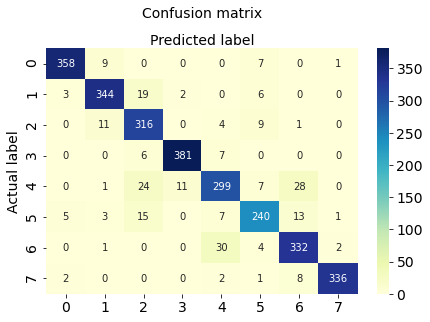

In [25]:
cnf_matrix = confusion_matrix(y_test, predicted_labels)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [26]:
print("Accuracy:", accuracy_score(y_test, predicted_labels))

Accuracy: 0.9124649859943977


In [27]:
grid_svm.best_estimator_.feature_names = list(human.var_names)

**Predict cell types in the other datasets (mouse and chick)**

In [29]:
def process_and_subset_data(adata, genes):
    # save the log transformed counts as raw 
    adata.raw = adata.copy()
    # Per cell normalization
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    # Log transformation 
    sc.pp.log1p(adata)
    # Subset data
    adata = adata[:, list(genes)]
    # Scale
    sc.pp.scale(adata, max_value=10)
    return adata

In [30]:
def process_data(adata):
    # Per cell normalization
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    # Log transformation 
    sc.pp.log1p(adata)
    # Scale
    sc.pp.scale(adata, max_value=10)

In [31]:
import scipy
def make_single_predictions(adata, classifier): 
    #if scipy.sparse.issparse(adata.X):
        #adata.X = adata.X.toarray()
    adata_X = np.array(adata.X)
    print(type(adata_X), adata_X.shape)
    adata_preds = classifier.predict(adata_X)
    adata.obs['human_classifier_supporting'] = adata_preds
    print(adata.obs.human_classifier_supporting.value_counts(dropna = False))

In [32]:
def make_correspondence(classifier):
    corr = {}
    for i in range(0,len(classifier.classes_)):
            corr[i] = classifier.classes_[i]
    return corr

In [33]:
def make_probability_predictions(adata, classifier):
    adata_X = np.array(adata.X)
    print(type(adata_X), adata_X.shape)
    proba_preds = classifier.predict_proba(adata_X)
    df_probs = pd.DataFrame(np.column_stack(list(zip(*proba_preds))))
    corr = make_correspondence(classifier)
    for index in df_probs.columns.values:
        celltype = corr[index]
        adata.obs['prob_'+celltype] = df_probs[index].to_list()

Monkey ovary (Zhao et al., 2020)

In [34]:
monkey = process_and_subset_data(monkey, grid_svm.best_estimator_.feature_names)
make_single_predictions(monkey, grid_svm.best_estimator_)

normalizing by total count per cell
/home/jovyan/my-conda-envs/scanpy_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
/home/jovyan/my-conda-envs/scanpy_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/scanpy_env/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


<class 'numpy.ndarray'> (2981, 300)
preGC_I_OSR1    905
preGC_II        477
sKITLG          452
ovarianSurf     378
preGC_III       294
coelEpi         231
sLGR5           151
sPAX8b           93
Name: human_classifier_supporting, dtype: int64


In [35]:
make_probability_predictions(monkey, grid_svm.best_estimator_)

<class 'numpy.ndarray'> (2981, 300)


In [36]:
monkey

AnnData object with n_obs × n_vars = 2981 × 300
    obs: 'stage', 'percent_mito', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'doublet_score_0.75', 'leiden', 'cell_type', 'human_classifier_supporting', 'prob_coelEpi', 'prob_ovarianSurf', 'prob_preGC_II', 'prob_preGC_III', 'prob_preGC_I_OSR1', 'prob_sKITLG', 'prob_sLGR5', 'prob_sPAX8b'
    var: 'monkey_ENSEMBL', 'human_ENSEMBL', 'human_gene_ortholog', 'monkey_gene_name', 'n_cells', 'mean', 'std'
    uns: 'log1p'

In [37]:
monkey.write('/nfs/team292/vl6/Monkey_Zhao/supporting_cells_with_human_preds.h5ad')

... storing 'human_classifier_supporting' as categorical


In [39]:
monkey = sc.read('/nfs/team292/vl6/Monkey_Zhao/supporting_cells_with_human_preds.h5ad')
monkey

AnnData object with n_obs × n_vars = 2981 × 300
    obs: 'stage', 'percent_mito', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'doublet_score_0.75', 'leiden', 'cell_type', 'human_classifier_supporting', 'prob_coelEpi', 'prob_ovarianSurf', 'prob_preGC_II', 'prob_preGC_III', 'prob_preGC_I_OSR1', 'prob_sKITLG', 'prob_sLGR5', 'prob_sPAX8b'
    var: 'monkey_ENSEMBL', 'human_ENSEMBL', 'human_gene_ortholog', 'monkey_gene_name', 'n_cells', 'mean', 'std'

In [40]:
monkey_predictions = monkey.obs[['prob_coelEpi', 'prob_ovarianSurf', 'prob_preGC_II', 'prob_preGC_III', 'prob_preGC_I_OSR1', 'prob_sKITLG', 'prob_sLGR5', 'prob_sPAX8b']]

In [41]:
monkey_predictions.columns = ['prob_coelEpi', 'prob_ovarianSurf', 'prob_preGC-II', 'prob_preGC-II-late', 'prob_preGC-I', 
                              'prob_sKITLG', 'prob_sLGR5', 'prob_sPAX8b']

In [42]:
monkey_predictions.head()

,prob_coelEpi,prob_ovarianSurf,prob_preGC-II,prob_preGC-II-late,prob_preGC-I,prob_sKITLG,prob_sLGR5,prob_sPAX8b
AAACCCAGTGACTCGC_1,0.207227,0.060186,0.050789,0.100887,0.102496,0.154205,0.172971,0.151241
AAACGAACAGGTGGAT_1,0.076051,0.034528,0.078120,0.112996,0.163759,0.477127,0.048087,0.009333
AAACGAATCTAGCCAA_1,0.005410,0.007092,0.032258,0.002344,0.143123,0.787747,0.021622,0.000403
AAACGCTAGTGCGCTC_1,0.060669,0.018931,0.017040,0.021659,0.745201,0.025501,0.096990,0.014008
AAACGCTGTCATACCA_1,0.011572,0.144941,0.584065,0.012766,0.192707,0.032703,0.016379,0.004867


In [43]:
monkey_predictions.to_csv("/nfs/team292/vl6/Monkey_Zhao/macaque_Zhao2020_supporting_predictions.csv")